<a href="https://colab.research.google.com/github/taylorsm9/twitter_ner/blob/main/NERColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%%

!pip install datasets -q
!pip install tokenizers -q
!pip install transformers -q
!pip install seqeval -q
!pip install nltk emoji==0.6.0 
import configparser
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, BertTokenizerFast, TFBertModel, TFAutoModel, TFRobertaModel
import warnings
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pydot
import graphviz
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

!git clone https://github.com/taylorsm9/twitter_ner


     |████████████████████████████████| 451 kB 5.0 MB/s 
     |████████████████████████████████| 182 kB 14.6 MB/s 
     |████████████████████████████████| 212 kB 42.1 MB/s 
     |████████████████████████████████| 115 kB 39.3 MB/s 
     |████████████████████████████████| 127 kB 26.5 MB/s 
     |████████████████████████████████| 7.6 MB 5.2 MB/s 
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 43 kB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 2.8 MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49735 sha256=ea05df135b28b192554a2075b753df1f112e5f60e48f86e73a11b44b53a022a1
  Stored in directory: /root/.cache/pip/wheels/4e/bf/6b/2e22b3708d14bf6384f862db539b044d6931bd6b14ad3c9adc
Successfully built emoji
Cloning into 'twitter_ner'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72

In [2]:
#DEFS 
config = configparser.ConfigParser()
config.read('twitter_ner/src/config.ini')

# INI file variables, descriptions in INI file
model_type = int(config["MODEL"]['MODEL_TYPE'])
dataset = int(config["DATA"]['DATASET'])
MAX_LEN = int(config["TRAINING"]['MAX_LEN'])
train_batch_size = int(config["TRAINING"]['TRAIN_BATCH_SIZE'])
test_batch_size = int(config["TRAINING"]['TEST_BATCH_SIZE'])
epochs = int(config["TRAINING"]['EPOCHS'])
model_path = config["TRAINING"]['MODEL_PATH']


def pred(val_input_ids,val_attention_mask):
    return model.predict([val_input_ids,val_attention_mask], batch_size=1)

def testing(val_input_ids,val_attention_mask,enc_tag,y_test):
    val_input = val_input_ids.reshape(1,128)
    val_attention = val_attention_mask.reshape(1,128)

    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    print("Original Text : ",str(sentence))
    print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    print("Original Tags : " ,str(true_enc_tag))
    print("\n")

    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1)
    pred_without_pad = pred_with_pad[pred_with_pad>0]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)

    print("Predicted Tags : ",pred_enc_tag)
    print("Test Accuracy: {}".format(sklearn.metrics.accuracy_score(pred_enc_tag, true_enc_tag)))
    #print("Test F1-Score: {}".format(sklearn.metrics.f1_score(pred_enc_tag, true_enc_tag)))
    #print("Test F1-Score: {}".format(classification_report(true_enc_tag, pred_enc_tag,digits=4)))

def set_vars(model_type, dataset):
    if model_type == 1:
        _base_model_path = "vinai/bertweet-base"
        _tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
        _pretrained_model = TFAutoModel.from_pretrained("vinai/bertweet-base")
        _model_name = "bertweet_"
    elif model_type == 0:
        _base_model_path = "bert-base-uncased"
        _tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        _pretrained_model = TFBertModel.from_pretrained('bert-base-uncased')
        _model_name = "bert_"

    if dataset == 1:
        _training_file = "twitter_ner/data/pos_tweets.csv"
        _model_name += "twitter"
    elif dataset == 0:
        _training_file = "twitter_ner/data/pos_news.csv"
        _model_name += "news"
    return _base_model_path, _tokenizer, _pretrained_model, _training_file, _model_name

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks, return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(5,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def load_model(model_path, model_name):
    if model_type == 1:
        _loaded_model = tf.keras.models.load_model(model_path + model_name,
                                                  custom_objects={"TFRobertaModel": TFRobertaModel})

    elif model_type == 0:
        _loaded_model = tf.keras.models.load_model(model_path + model_name,
                                                  custom_objects={"TFBertModel": TFBertModel})
    return _loaded_model

def tokenize(data,max_len = MAX_LEN):
    _input_ids = list()
    attention_mask = list()
    for n in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[n],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


        _input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(_input_ids),np.vstack(attention_mask)

def process_data(data_path):
    #Pandas wants to warn us about behavior in the version we are using. We want this behavior
    warnings.simplefilter("ignore", category=FutureWarning)

    df = pd.read_csv(data_path, encoding="utf-8")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")
    #df[df.columns[0]] = df["Sentence #"].fillna(method="ffill")
    #df.isetitem(0, df["Sentence #"].fillna(method="ffill"))

    _enc_pos = preprocessing.LabelEncoder()
    _enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = _enc_pos.fit_transform(df["POS"])
    #df[df.columns[1]] = _enc_pos.fit_transform(df["POS"])
    #df.isetitem(1, _enc_pos.fit_transform(df["POS"]))
    df.loc[:, "Tag"] = _enc_tag.fit_transform(df["Tag"])
    #df[df.columns[2]] = _enc_pos.fit_transform(df["Tag"])
    #df.isetitem(2, _enc_pos.fit_transform(df["Tag"]))

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    _pos = df.groupby("Sentence #")["POS"].apply(list).values
    _tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, _pos, _tag, _enc_pos, _enc_tag

In [3]:

base_model_path, tokenizer, pretrained_model, training_file, model_name = set_vars(model_type, dataset)



Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [4]:
dataframe = pd.read_csv(training_file,encoding = 'utf-8', on_bad_lines = 'skip')
dataframe = dataframe.dropna()
dataframe.head()

print(f"Number of Tags : {len(dataframe.Tag.unique())}")
pie = dataframe['Tag'].value_counts()
px.pie(names = pie.index,values= pie.values,hole = 0.5,title ='Total Count of Tags')

print(f"Number of POS Tags : {len(dataframe['POS'].unique())}")
bar = dataframe['POS'].value_counts()
px.bar(x = bar.index,y = bar.values,title = "Total Count of Parts of Speech",color = bar.index)


Number of Tags : 5
Number of POS Tags : 17


In [5]:
sentence,pos,tag,enc_pos,enc_tag = process_data(training_file)


In [6]:
X_train,X_test,y_train,y_test = train_test_split(sentence,tag,random_state=13,test_size=0.1)

X_train.shape,X_test.shape,y_train.shape,y_test.shape


input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)


100%|██████████| 350/350 [00:00<00:00, 601.81it/s]


In [7]:

#Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (128-len(y_test[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (128-len(y_train[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)


{128}

In [9]:
model = create_model(pretrained_model,MAX_LEN)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

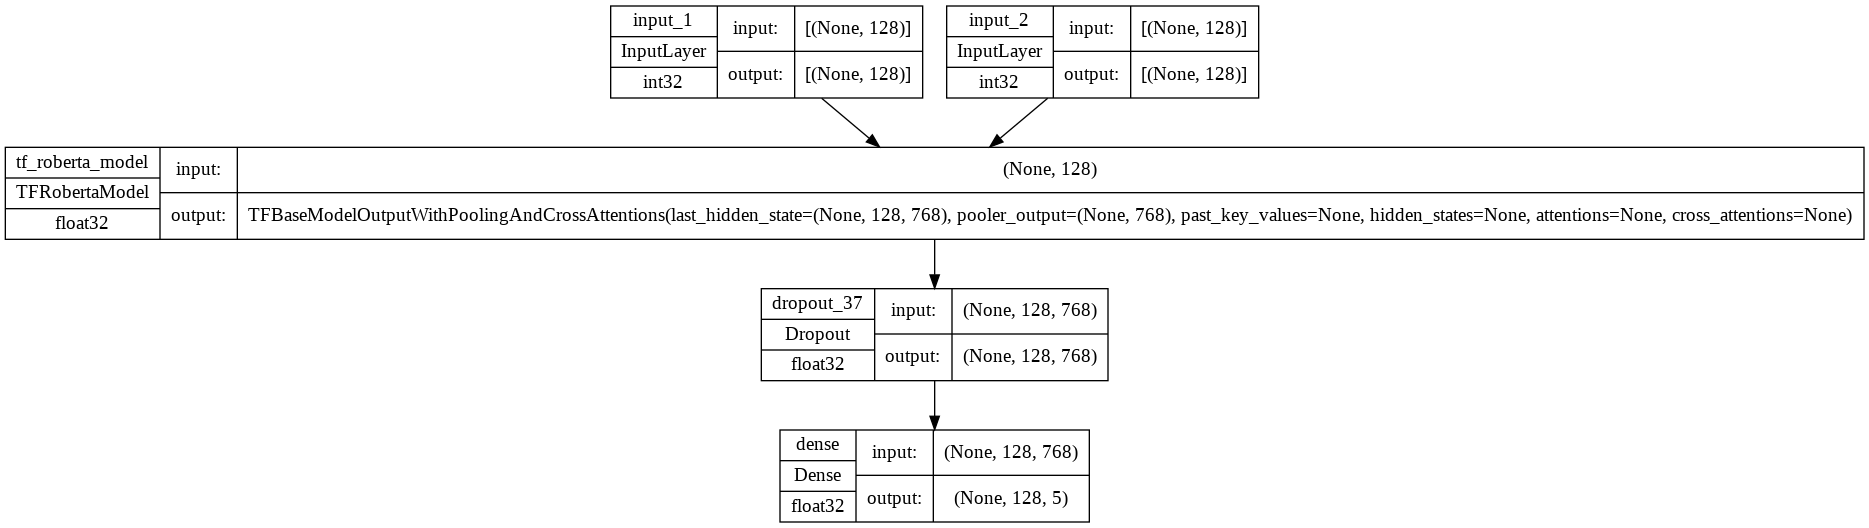

In [10]:
tf.keras.utils.plot_model(model,show_shapes=True, show_dtype=True)


In [ ]:
#TRAIN
early_stopping = EarlyStopping(mode='min',patience=5)
history_bert = model.fit([input_ids, attention_mask],
                         np.array(train_tag),
                         validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),
                         epochs = epochs,batch_size = train_batch_size,
                         callbacks = early_stopping,verbose = True)

Epoch 1/2
  1/394 [..............................] - ETA: 1:19:02 - loss: 0.8303 - accuracy: 0.8477

In [ ]:
#save model for reuse
model.save(model_path + model_name, save_format="h5", include_optimizer=False)
print("done")

In [ ]:
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def testing(enc_tag,y_test):
  val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)
  pred_tags = []
  true_tags = []
  for x, z,y in zip(val_input_ids, val_attention_mask, y_test):
    val_input = x.reshape(1,128)
    val_attention = z.reshape(1,128)
    true_enc_tag = enc_tag.inverse_transform(y)

    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1)
    pred_without_pad = pred_with_pad[pred_with_pad>0]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)

    # This section is a hack. Our prediction is bugged such that we sometimes predict a list of a different size
    # than the label list. This may be a local issue, unfortunately we do not have time to test it in colab.
    pred_list = []
    true_list = []
    pred_list.extend(pred_enc_tag)
    true_list.extend(true_enc_tag)
    if len(pred_list) == len(true_list):
        pred_tags.extend(pred_enc_tag)
        true_tags.extend(true_enc_tag)
    else:
        print(pred_list)
        print(true_list)
        print("off by " + str((len(pred_list) - len(true_list))))

    pred_list = []
    true_list = []

  # Print metrics
  print(pred_tags)
  print(true_tags)
  print("Test Accuracy: {}".format(metrics.accuracy_score(pred_tags, true_tags)))
  print("Test F1-Score: {}".format(classification_report(true_tags, pred_tags,digits=4)))
testing(enc_tag,y_test)